<a href="https://colab.research.google.com/github/JoseAguirre-10/Tarea-2-Opti.-Mat./blob/main/Tarea_2_Jos%C3%A9_Aguirre_Mat%C3%ADas_Meneses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PREGUNTA 1

In [ ]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 26.9 MB/s eta 0:00:00


In [ ]:
!pip install gurobipy networkx matplotlib


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque


#conjunto de los arcos con sus respectivos costos por productos, (i,j) es el arco definido de un nodo a otro.
c = {(1,2):10, (1,3):25, (1,4):30, (1,7):20, (2,5):15, (2,6):15,(3,6):15,(4,7):10, (5,8):25, (6,8):80,(7,8):25}
#costos de bodega asignado a cada nodo
beta = {2:100, 3:120, 4:130, 5:140, 6:150, 7:200}

#arcos con capacidad máxima de 500
b1 = {(1,2):500,(1,4):500,(4,7):500,(7,8):500,(6,8):500}
#arcos con capacidad máxima de 350
b2 = {(1,3):350,(3,6):350,(2,6):350}
#arcos con capacidad máx. de 250
b3 = {(2,5):250}
#arcos con capacidad máx. de 800
b4 = {(5,8):800}
#arcos con capacidad máx. de 600
b5 = {(1,7):600}

#capacidad máxima de los arcos
capacidad = {**b1, **b2, **b3, **b4, **b5}



In [ ]:

# Crear modelo
m = gp.Model("flujo_optimo")

# Variables de flujo, se genera una por índice, y cada índice tiene una cota superior indicada
x = m.addVars(c.keys(), lb=0,ub = capacidad,  vtype=GRB.CONTINUOUS, name="x")

# definiendo la función objetivo
obj_transporte = gp.quicksum(c[i,j] * x[i,j] * x[i,j] for (i,j) in c)
obj_bodegaje = gp.quicksum(beta[i] * gp.quicksum(x[k,i] for (k,j) in c if j == i) for i in beta)
m.setObjective(obj_transporte + obj_bodegaje, GRB.MINIMIZE)

# Restricciones de la función
#la suma de la salida del nodo 1 debe ser 1000
m.addConstr(gp.quicksum(x[1,j] for (i,j) in c if i == 1) == 1000)
#la suma de la llegada del nodo 8 debe ser 1000
m.addConstr(gp.quicksum(x[i,8] for (i,j) in c if j == 8) == 1000)

#lo que llega a una bodega, sale también de la bodega (no se quedan artículos en estas)
for i in range(2, 8):
    entrada = gp.quicksum(x[k,i] for (k,j) in c if j == i)
    salida = gp.quicksum(x[i,j] for (i2,j) in c if i2 == i)
    m.addConstr(salida - entrada == 0)

# Optimizar
m.optimize()

flujo = {(i,j): x[i,j].X for (i,j) in x if x[i,j].X > 1e-6}
G = nx.DiGraph()
for (i,j), f in flujo.items():
    G.add_edge(i, j, weight=f)
# Construir el grafo con arcos que tienen flujo positivo
if m.status == GRB.OPTIMAL:
    print(f"\nCosto total óptimo: {m.ObjVal:.2f}")
    for (i,j) in x:
        f = x[i,j].X
        if f > 1e-6:
            print(f"Flujo {i} → {j}: {f:.2f} / Capacidad: {capacidad[i,j]}")

grafo = defaultdict(list)
for (i,j), val in flujo.items():
    grafo[i].append(j)



Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 8 rows, 11 columns and 22 nonzeros
Model fingerprint: 0x6224c693
Model has 11 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+02, 2e+02]
  QObjective range [2e+01, 2e+02]
  Bounds range     [2e+02, 8e+02]
  RHS range        [1e+03, 1e+03]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 7 rows, 11 columns, 18 nonzeros
Presolved model has 11 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 7.000e+00
 Factor NZ  : 2.800e+01
 Factor Ops : 1.400e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
  

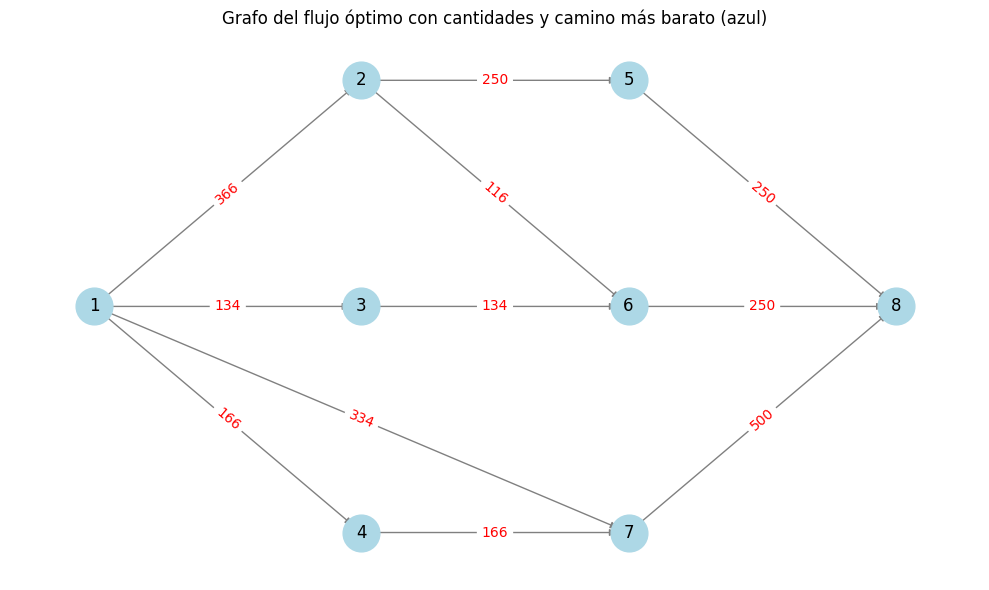

In [ ]:

G = nx.DiGraph()

for (i,j), f in flujo.items():
    G.add_edge(i, j, weight=f)

pos = {
    1: (0, 0),
    2: (1, 1),
    3: (1, 0),
    4: (1, -1),
    5: (2, 1),
    6: (2, 0),
    7: (2, -1),
    8: (3, 0) }

plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)
nx.draw_networkx_labels(G, pos, font_size=12)
# Todos los arcos usados
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='gray', arrows=True)

# Etiquetas de flujo
edge_labels = {(i,j): f"{G[i][j]['weight']:.0f}" for (i,j) in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Resaltar el camino más barato

plt.title("Grafo del flujo óptimo con cantidades y camino más barato (azul)")
plt.axis('off')
plt.tight_layout()
plt.show()

PREGUNTA 2

In [ ]:
from gurobipy import*

#mejor utilizamos librerias para resolver el problema
#Definimos las Matrices

betha = {
    0:0,
    1:100,
    2:120,
    3:130,
    4:140,
    5:150,
    6:200,
    7:0
} #betha es un vector columna


c = {
    0:{1:10, 2:25, 3:30, 6:20},
    1:{4:15, 5:15},
    2:{5:15, 6:0},
    3:{6:10},
    4:{7:25},
    5:{7:80},
    6:{7:25},
    7:{}
}  # c es una matriz de 8x8


r = {
    0: {1: 500, 2: 350, 3: 500, 6: 600},
    1: {4: 250, 5: 350},
    2: {5: 350},
    3: {6: 500},
    4: {7: 800},
    5: {7: 500},
    6: {7: 500},
    7: {}
}  # r es una matriz de 8x8

n = 8

#DEFINICIOÓN DE CONSTANTES PARA ITERACIÓN.
mu = 1
n= 8
epsilon = 10**-5
for k in range(10):
  m2 = Model('Penalización')

  x = m2.addVars(n,n, vtype= GRB.CONTINUOUS,lb= 0, name = 'elemtos_por_bodega')

  R0 = quicksum(x[0, j] for j in range(n)) - 1000

  R1 = quicksum(x[i,7] for i in range(n)) - 1000

  R2 = []  # Balance de flujo para nodos intermedios

  for l in range(1, 7):
      R2.append(quicksum(x[i,l] for i in range(n)) - quicksum(x[l, j] for j in range(n)))

  #Esto de aca define las cotas inferiores y superiores Q en las cuales esta definido x

  for i in range(n):
      for j in range(n):
          if j in r[i]:  # Asegurar que la ruta existe
              m2.addConstr(x[i,j] <= r[i][j], f"Cota_superior_{i}_{j}")
          else:
            m2.addConstr(x[i,j] == 0, f"No_negatividad_{i}_{j}")

  #entonces ahora debemos definir phi

  costo_transporte = quicksum(c[i][j] * x[i,j] * x[i,j] for i in range(n) for j in c[i])
  costo_bodegaje = quicksum(betha[j] * quicksum(x[i,j] for i in range(n)) for j in range(n))

  f = costo_transporte + costo_bodegaje

  penalizacion = R0 * R0 + R1 * R1 + quicksum(r * r for r in R2)

  m2.setObjective(f + mu * penalizacion, GRB.MINIMIZE)

  # Resolver
  m2.setParam('OutputFlag', 0)
  m2.optimize()


  if m2.status == GRB.OPTIMAL:
      #imprimir el resultado que obtuvimos y evaluarlo
      R2_value = [r.getValue() for r in R2]
      valor_penalizacion = (R0.getValue()**2 + R1.getValue()**2 + sum(r**2 for r in R2_value))
      print(f"Iteración {k+1}: mu={mu}, penalización={mu*valor_penalizacion:.2f}, f(x) = {f.getValue():.2f}, Phi(x) = {f.getValue()+mu*valor_penalizacion:.2f}")
      print('El resultado es el siguiente: ')
      #debemos empezar agregar las condiciones para seguir o no seguir iterando
      if valor_penalizacion < epsilon or k ==9: #se deja de iterar y se imprime el resutlado
        print("Solución óptima encontrada:")

      for i in range(n):
          for j in range(n):
              if x[i, j].x > 1e-6:  # Evitar imprimir valores cercanos a cero
                  print(f'x[{i},{j}] = {x[i, j].x:.2f}')

      if valor_penalizacion	>= epsilon or k!=9:
        mu= 10*mu
  else:
    print("No se encontró solución óptima")


Iteración 1: mu=1, penalización=1547815.68, f(x) = 216375.07, Phi(x) = 1764190.74
El resultado es el siguiente: 
x[0,1] = 71.74
x[0,2] = 29.87
x[0,3] = 24.89
x[0,6] = 36.83
x[1,4] = 2.16
x[1,5] = 0.35
x[4,7] = 35.34
x[5,7] = 11.32
x[6,7] = 36.67
Iteración 2: mu=10, penalización=4378121.07, f(x) = 4611713.15, Phi(x) = 8989834.22
El resultado es el siguiente: 
x[0,1] = 256.88
x[0,2] = 111.02
x[0,3] = 99.08
x[0,6] = 173.51
x[1,4] = 109.75
x[1,5] = 49.49
x[2,5] = 35.05
x[3,6] = 43.29
x[4,7] = 183.73
x[5,7] = 68.65
x[6,7] = 214.32
Iteración 3: mu=100, penalización=1967884.66, f(x) = 14765241.81, Phi(x) = 16733126.46
El resultado es el siguiente: 
x[0,1] = 351.31
x[0,2] = 126.82
x[0,3] = 154.65
x[0,6] = 304.92
x[1,4] = 250.00
x[1,5] = 74.65
x[2,5] = 96.83
x[3,6] = 139.40
x[4,7] = 288.55
x[5,7] = 156.76
x[6,7] = 444.00
Iteración 4: mu=1000, penalización=435925.37, f(x) = 18664638.58, Phi(x) = 19100563.95
El resultado es el siguiente: 
x[0,1] = 357.96
x[0,2] = 129.85
x[0,3] = 167.46
x[0,6] = 3